In [ ]:
#!pip install karateclub

In [ ]:
import torch
torch.cuda.is_available()  # Returns True if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#tensor = tensor.to(device)

In [ ]:
#website link
#https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=pcr9joFQ6Mri
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.6.0+cu124
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#!pip install torch-geometric torch-sparse torch-scatter # Install necessary libraries
#!pip install torch-cluster
!pip install torch-geometric
#!pip install torch-geometric-temporal
import torch
#from torch_geometric.nn import knn_graph
from torch_cluster import knn_graph
# Assuming you have a feature matrix X
x = torch.randn(100, 64)  # 100 nodes, 64 features

# Create a k-nearest neighbor graph
edge_index = knn_graph(x, k=10)


In [ ]:
!pip install -U imbalanced-learn

In [ ]:
# Import necessary libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN # ... or any other desired oversampling techniques

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, accuracy_score
import numpy as np


def compute_threshold(y_true, y_scores):
  # Assume `y_true` is the true labels and `y_scores` are the predicted probabilities
  #thresholds = np.linspace(0, 1, 100)
  #best_threshold = 0
  thresholds = np.linspace(0, 1, 100)
  best_threshold = 0
  best_f1 = 0

  for threshold in thresholds:
    y_approx = (y_scores >= threshold).astype(int)
    f1 = f1_score(y_true, y_approx)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

  #print(f"Best threshold: {best_threshold}, Best F1 Score: {best_f1}")
  return best_threshold,best_f1

def compute_acc_threshold(y_true, y_scores):
  # Assume `y_true` is the true labels and `y_scores` are the predicted probabilities
  #thresholds = np.linspace(0, 1, 100)
  #best_threshold = 0
  thresholds = np.linspace(0, 1, 100)
  best_threshold = 0
  best_acc = 0

  for threshold in thresholds:
    y_approx = (y_scores >= threshold).astype(int)
    acc = accuracy_score(y_true, y_approx)
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

  #print(f"Best threshold: {best_threshold}, Best F1 Score: {best_f1}")
  return best_threshold,best_acc

def compute_precision_recall(y_true, y_scores):
    # Compute precision, recall, and thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    idx_max_precision = np.argmax(precisions[:-1])  # Exclude last point where threshold=1
    best_threshold_for_precision = thresholds[idx_max_precision]
    #print(f"Threshold for max precision: {best_threshold_for_precision}, Precision: {precisions[idx_max_precision]}")
    idx_max_recall = np.argmax(recalls[:-1])
    best_threshold_for_recall = thresholds[idx_max_recall]
    #print(f"Threshold for max recall: {best_threshold_for_recall}, Recall: {recalls[idx_max_recall]}")
    return best_threshold_for_precision,best_threshold_for_recall




In [ ]:
def threshold_option(y_true,y_approx,option):
  if option==0:
    th=0.5

  elif option==1:

    #th,best_acc=compute_acc_threshold(y_true, y_approx)
    th,f1=compute_threshold(y_true, y_approx)

  elif option==2:
    presicion_th,th=compute_precision_recall(y_true, y_approx)
    #th contains recall threshold
  else:
    th,recall_threshold=compute_precision_recall(y_true, y_approx)
    #th contains precesion threshold
  return th

def binary_predictions(predictions,threshold):
    return np.where(predictions > threshold, 1, 0)




In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
class GCAdam(Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, gc_conv_only=False):
        super(GCAdam,self).__init__(params, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.gc_conv_only = gc_conv_only

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue

                # Gradient Centralization
                grad = param.grad.data
                if not self.gc_conv_only or grad.dim() > 1:
                    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))

        super(GCAdam, self).step(closure)

class GaussianRBFNetworkC(nn.Module):
    def __init__(self, gaussian_regularizer, centers_regularizer, weights_regularizer, learnable_centers,
                 centers, device='cuda'):
        super(GaussianRBFNetworkC, self).__init__()

        self.device = device
        self.gaussian_regularizer = gaussian_regularizer
        self.centers_regularizer = centers_regularizer
        self.weights_regularizer = weights_regularizer
        self.centers = centers
        self.learnable_centers = learnable_centers
        self.n_centers = centers.shape[0]
        self.n_features = centers.shape[1]
        # Define learnable parameters
        self.precision_elements = nn.Parameter(torch.randn(self.n_features * (self.n_features + 1) // 2)
                                               .to(self.device))
        if self.learnable_centers == True:
            self.centers = nn.Parameter(centers.to(self.device))
        else:
            self.centers_regularizer = 1e-32
        self.weights = nn.Parameter(torch.randn(self.n_centers)
                                    .to(self.device))

    def compute_precision(self, precision_elements):

        lower_tri = torch.zeros((self.n_features, self.n_features)).to(self.device)
        idx = torch.tril_indices(*lower_tri.shape)
        lower_tri[idx[0], idx[1]] = precision_elements
        precision_matrix = torch.matmul(lower_tri, lower_tri.T)
        return precision_matrix

    def forward(self, X):

        precision_matrix = self.compute_precision(self.precision_elements)
        diff = X[:, None, :] - self.centers.unsqueeze(0)



        Phi = torch.exp(-0.5 * torch.einsum('ijk, kl, ijl -> ij', diff, precision_matrix, diff))

        #self.bn = nn.BatchNorm1d(Phi)  # Initialize BatchNorm1d layer
        #y_hat = torch.relu(torch.batch_norm(input= Phi , weights= self.weights,bias=None,running_mean=None,running_var=None,training=False,momentum=0.001,eps=0.0000001,cudnn_enabled=False))
        '''y_hat = torch.relu(torch.nn.functional.batch_norm(input=Phi, running_mean=torch.zeros(Phi.shape[1], device=self.device),
                                                         running_var=torch.ones(Phi.shape[1], device=self.device),
                                                          weight=self.weights,bias=None, training=False, momentum=0.1, eps=1e-05)) # shape (batch_size,)'''
        '''variance=X.var(dim=0)
        diff=diff/variance
        y_hat = torch.relu(torch.nn.functional.batch_norm(input=Phi, running_mean=diff,
                                                         running_var=variance[None,:],
                                                          weight=self.weights,bias=None, training=False, momentum=0.1, eps=1e-05)) # shape (batch_size,)'''

        y_hat = torch.sigmoid(Phi @ self.weights)
        #y_hat=torch.tanh(Phi @ self.weights)
        #y_hat = min(torch.relu(Phi @ self.weights)*torch.sigmoid(Phi @ self.weights),1)
        #y_hat=torch.sigmoid(y_hat)
        return y_hat

    def evaluate_loss(self, y, y_hat):

        bce_loss = nn.BCELoss()
        loss = bce_loss(y_hat, y)
        reg_gaussian = self.gaussian_regularizer * torch.linalg.norm(self.precision_elements)
        reg_centers = self.centers_regularizer * torch.linalg.norm(self.centers)
        reg_weights = self.weights_regularizer * torch.linalg.norm(self.weights)
        loss = loss + reg_gaussian + reg_centers + reg_weights
        return loss

    def feature_importance(self, precision_matrix):

        eigenvalues, eigenvectors = torch.linalg.eigh(precision_matrix)
        feature_importance = torch.matmul(torch.abs(eigenvectors), eigenvalues)
        return feature_importance / torch.sum(feature_importance), eigenvalues, eigenvectors

In [ ]:
class GaussianRBFNetworkCBias(nn.Module):
    def __init__(self, gaussian_regularizer, centers_regularizer, weights_regularizer, learnable_centers,
                 centers,bias_regularizer=1e-6, device='cuda'):
        super(GaussianRBFNetworkCBias, self).__init__()

        self.device = device
        self.gaussian_regularizer = gaussian_regularizer
        self.centers_regularizer = centers_regularizer
        self.weights_regularizer = weights_regularizer
        self.centers = centers
        self.learnable_centers = learnable_centers
        self.bias_regularizer = bias_regularizer
        self.bias = nn.Parameter(torch.zeros(1).to(self.device))  # Add bias
        self.n_centers = centers.shape[0]
        self.n_features = centers.shape[1]
        # Define learnable parameters
        self.precision_elements = nn.Parameter(torch.randn(self.n_features * (self.n_features + 1) // 2)
                                               .to(self.device))
        if self.learnable_centers == True:
            self.centers = nn.Parameter(centers.to(self.device))
        else:
            self.centers_regularizer = 1e-32
        self.weights = nn.Parameter(torch.randn(self.n_centers)
                                    .to(self.device))


    def compute_precision(self, precision_elements):

        lower_tri = torch.zeros((self.n_features, self.n_features)).to(self.device)
        idx = torch.tril_indices(*lower_tri.shape)
        lower_tri[idx[0], idx[1]] = precision_elements
        precision_matrix = torch.matmul(lower_tri, lower_tri.T)
        return precision_matrix

    def forward(self, X):

        precision_matrix = self.compute_precision(self.precision_elements)
        diff = X[:, None, :] - self.centers.unsqueeze(0)



        Phi = torch.exp(-0.5 * torch.einsum('ijk, kl, ijl -> ij', diff, precision_matrix, diff))

        #self.bn = nn.BatchNorm1d(Phi)  # Initialize BatchNorm1d layer
        #y_hat = torch.relu(torch.batch_norm(input= Phi , weights= self.weights,bias=None,running_mean=None,running_var=None,training=False,momentum=0.001,eps=0.0000001,cudnn_enabled=False))
        '''y_hat = torch.relu(torch.nn.functional.batch_norm(input=Phi, running_mean=torch.zeros(Phi.shape[1], device=self.device),
                                                         running_var=torch.ones(Phi.shape[1], device=self.device),
                                                          weight=self.weights,bias=None, training=False, momentum=0.1, eps=1e-05)) # shape (batch_size,)'''
        '''variance=X.var(dim=0)
        diff=diff/variance
        y_hat = torch.relu(torch.nn.functional.batch_norm(input=Phi, running_mean=diff,
                                                         running_var=variance[None,:],
                                                          weight=self.weights,bias=None, training=False, momentum=0.1, eps=1e-05)) # shape (batch_size,)'''

        #y_hat = torch.sigmoid(Phi @ self.weights)

        y_hat = torch.sigmoid(Phi @ self.weights + self.bias)  # Include bias
        #y_hat=torch.tanh(Phi @ self.weights)
        #y_hat = min(torch.relu(Phi @ self.weights)*torch.sigmoid(Phi @ self.weights),1)
        #y_hat=torch.sigmoid(y_hat)
        return y_hat

    def evaluate_loss(self, y, y_hat):

        bce_loss = nn.BCELoss()
        loss = bce_loss(y_hat, y)
        reg_bias = self.bias_regularizer * torch.linalg.norm(self.bias)  # Bias regularization
        reg_gaussian = self.gaussian_regularizer * torch.linalg.norm(self.precision_elements)
        reg_centers = self.centers_regularizer * torch.linalg.norm(self.centers)
        reg_weights = self.weights_regularizer * torch.linalg.norm(self.weights)
        loss = loss + reg_gaussian + reg_centers + reg_weights+reg_bias
        return loss

    def feature_importance(self, precision_matrix):

        eigenvalues, eigenvectors = torch.linalg.eigh(precision_matrix)
        feature_importance = torch.matmul(torch.abs(eigenvectors), eigenvalues)
        return feature_importance / torch.sum(feature_importance), eigenvalues, eigenvectors

In [ ]:



#str='asthma_disease_data.csv' #vgood imbalance data
#str='heart.csv'  #v good on heart large version
#str='Breast_cancer_data.csv' #v good
#str='kidney_stone_urine_analysis.csv' #not good imbalance data
str='covid_19.csv' #good reasonable

#str='blood.csv'
#str='diabetes.csv'
#str='MBA.csv'
#str='loan_data.csv'

#str='corona.csv' #multiclassification

data=pd.read_csv(str)
#data.drop_duplicates(inplace=True)
# Preview the dataset
print(data.head())


data.isnull().sum()


print(data.head())
print(data.info())  # Check for missing values and data types
#data = data.sample(frac=0.2)
data.isna().sum()
data.isna().sum()

# Drop rows with missing values for simplicity (if applicable)
data = data.dropna()
#data = data.sample(frac=0.02)
# Assume the target variable is named 'output' (1 for heart attack, 0 for no heart attack)
# Adjust feature columns based on your dataset

#X = data.drop(columns=['target'])#['output'])  # Features
#y = data['target']#['output']  # Target variable
if str=='asthma_disease_data.csv':
  X=data.iloc[:,1:-1]
elif str=='covid_19.csv':
  data = data.sample(frac=0.2)
  X=data.iloc[:,:-1]
elif str=='MBA.csv' or str=='corona.csv' or str=='loan_data.csv':
  object_cols = data.select_dtypes(include=['object']).columns
  for col in object_cols:
    # Use Label Encoding to convert categorical features to numerical
    # This creates an ordinal relationship between categories
    # If categories have no inherent order, consider One-Hot Encoding instead
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col])
  X=data.iloc[:,:-1]
else:
  X=data.iloc[:,:-1]

y=data.iloc[:,-1]
print(X.head())

# Convert to numpy arrays
X = X.to_numpy() #values
y = y.to_numpy()#values


#from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
#X, y = adasyn.fit_resample(X, y)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# Standardize the data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_st = torch.tensor(X_train_st, dtype=torch.float32)
X_test_st = torch.tensor(X_test_st, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Check the shapes of the tensors
print(X_train_st.shape, y_train.shape)
print(X_test_st.shape, y_test.shape)

   Ind_ID  Cough_symptoms  Fever  Sore_throat  Shortness_of_breath  Headache  \
0       1               1      0            1                    0         0   
1       2               0      1            0                    0         0   
2       3               0      1            0                    0         0   
3       4               1      0            0                    0         0   
4       5               1      0            0                    0         0   

   Known_contact  Test Date  Covid_test_result  
0              1       2020                  0  
1              1       2020                  1  
2              1       2020                  1  
3              1       2020                  0  
4              2       2020                  0  
   Ind_ID  Cough_symptoms  Fever  Sore_throat  Shortness_of_breath  Headache  \
0       1               1      0            1                    0         0   
1       2               0      1            0                    

In [ ]:
import torch
from torch_geometric.data import Data

# Assuming you have your data as a pandas DataFrame:
import pandas as pd

# ... (load your data into a pandas DataFrame)

# Extract node features and labels
x = torch.tensor(X, dtype=torch.float32)

#for binary classification y is provided in the dataset csv
y = torch.tensor(y, dtype=torch.long)

#edge_index = knn_graph(x, k=2)#k=10) #v good for heart disease dataset
edge_index = knn_graph(x, k=2)

#edge_index=torch.tensor(torch.randint(0, x.shape[0],(2,x.shape[0])))



In [ ]:
import torch
from torch_geometric.data import Data

# Number of nodes
num_nodes = x.shape[0]
num_nodes_features=x.shape[1] # data.num_features

# Edge indices (self-loops only)
raw_edge_index = torch.arange(0, num_nodes, dtype=torch.long).repeat(2, 1)

# Graph data
data_raw = Data(x=x, edge_index=raw_edge_index,y=y)

In [ ]:
print(raw_edge_index.shape)
print(data_raw.x.shape)
print(data_raw.y.shape)

torch.Size([2, 1132])
torch.Size([1132, 8])
torch.Size([1132])


In [ ]:
import random
# Create a PyG Data object
data = Data(x=x, edge_index=edge_index, y=y)
#data=dataset[0]

num_nodes = data.num_nodes
num_nodes_features=data.num_features
#for binary classification
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask =  torch.zeros(num_nodes, dtype=torch.bool)

#for multilabel classification

#train_mask = torch.randint(0, cl, (num_nodes,))#torch.zeros(num_nodes, dtype=torch.bool)
#test_mask =  torch.randint(0, cl, (num_nodes,)) #torch.zeros(num_nodes, dtype=torch.bool)

'''
# Create a list of all node indices
all_node_indices = list(range(num_nodes))

# Shuffle the node indices randomly
random.shuffle(all_node_indices)

# Calculate the number of training nodes
num_train_nodes = int(4 * num_nodes / 5)

# Select the first num_train_nodes indices as training nodes
train_node_indices = all_node_indices[:num_train_nodes]

# Create the train_mask
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_node_indices] = True
# Create the test_mask
test_mask = ~train_mask  # Invert the train_mask'''
#train_mask[:int(4*num_nodes/5)]= True
#test_mask[int(4*num_nodes/5):] = True

test_mask[:int(1*num_nodes/5)]= True
train_mask=~test_mask

data.train_mask = train_mask
data.test_mask = test_mask

In [ ]:
print(data.x)
print(data.x.shape)

tensor([[2.3400e+02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.0000e+00,
         2.0200e+03],
        [3.2380e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.0000e+00,
         2.0200e+03],
        [5.2980e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.0000e+00,
         2.0200e+03],
        ...,
        [1.3900e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.0000e+00,
         2.0200e+03],
        [3.7610e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.0000e+00,
         2.0200e+03],
        [4.7420e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.0000e+00,
         2.0200e+03]])
torch.Size([1132, 8])


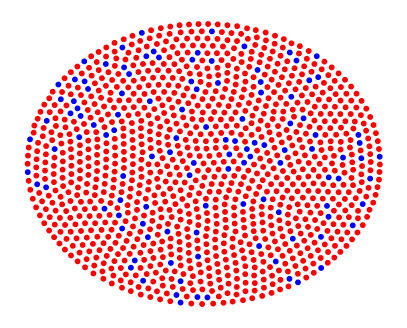

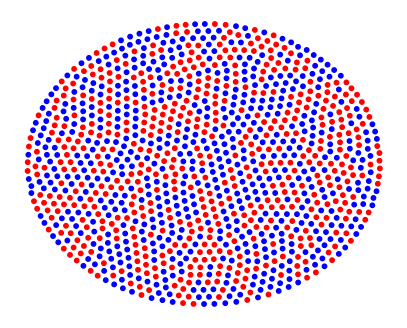

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
#import torch
import numpy as np
from torch_geometric.utils import to_networkx
#rand_labels=torch.randint(0, 8, (num_nodes,))
rand_labels=torch.randint(0, 2, (num_nodes,))
cluster_colors = ['red', 'blue', 'green', 'yellow', 'pink','orange', 'purple','brown']  # One color per cluster
node_colors_G_randomCluster = [cluster_colors[label] for label in rand_labels ]

# Create the first graph (G)
G = to_networkx(data_raw, to_undirected=True)  # or use `to_undirected=False` for a directed graph
node_colors = ['red' if data_raw.y[i].item() == 0 else 'blue' for i in range(num_nodes)]
G.remove_edges_from(nx.selfloop_edges(G))
# Now `G` is a NetworkX graph and can be used with NetworkX utilities
# For example, you can visualize it
plt.figure(figsize=(5, 4))
#nx.draw(G, with_labels=False, node_color='blue', node_size=10, edge_color='gray')
nx.draw(G, with_labels=False, node_color=node_colors, node_size=10, edge_color='gray',ax=plt.gca())
plt.show()
plt.figure(figsize=(5, 4))
#nx.draw(G, with_labels=False, node_color='blue', node_size=10, edge_color='gray')
nx.draw(G, with_labels=False, node_color=node_colors_G_randomCluster, node_size=10, edge_color='gray',ax=plt.gca())
plt.show()




In [ ]:
print(data.y[10].item())

0


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.glob import global_mean_pool
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# Load the Cora dataset
#dataset = Planetoid(root='/tmp/Cora', name='Cora')
#data = dataset[0]  # The graph data object

# Define the GNN encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,output_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, output_channels)
        self.conv3 = GCNConv(hidden_channels, output_channels)


    def forward(self, x, edge_index):

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        return x
        #x = F.relu(self.conv2(x, edge_index))
        #x = F.dropout(x, p=0.2, training=self.training)
        #return self.conv3(x, edge_index)#F.softmax(x,dim=1)   #

if x.shape[1]>20:
  embedding=x.shape[1]
else:
  embedding=2*x.shape[1]
#embedding=x.shape[1]#20#12#x.shape[1] #13 for heart disease dataset
embeddingout=32
# Define the DGI model
class DGI(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        #self.discriminator = torch.nn.Bilinear(64, 64, 1)  # For 64-dimensional embeddings
        self.discriminator = torch.nn.Bilinear(embedding,embedding,32)#embeddingout)#1)  # For 13-dimensional embeddings
    def forward(self, x, edge_index, corrupt_x):
        # Real embeddings
        z = self.encoder(x, edge_index)
        # Global embedding (mean pooling)
        g = global_mean_pool(F.softmax(z,dim=1),batch=None)
        # Corrupted embeddings
        z_corrupt = self.encoder(corrupt_x, edge_index)
        g = g.repeat(z.size(0), 1) # Repeat g to match z's batch dimension

        # Discriminator scores
        pos_score = self.discriminator(z, g)
        neg_score = self.discriminator(z_corrupt, g)
        return pos_score, neg_score




In [ ]:
# Initialize DGI model
hidden_channels=64
output_channels = embedding #3 #x.shape[1]  # Dimensionality of embeddings
#encoder = GCNEncoder(in_channels=dataset.num_node_features, hidden_channels=hidden_channels)
encoder = GCNEncoder(in_channels=x.shape[1], hidden_channels=hidden_channels,output_channels=output_channels)
dgi_model = DGI(encoder)
optimizer = torch.optim.Adam(dgi_model.parameters(), lr=0.01)

# Corruption function (shuffle node features)
def corrupt_features(x):
    #option1:
    return x[torch.randperm(x.size(0))]

    #option2: no corruption trivial case. No learning
    #return x

    #Option 3: add some noise from St.N Distr.
    #return x+0.01*torch.randn(x.size(0), x.size(1))

    #Option4 return x[torch.randperm(x.size(0))]
    #random_matrix = torch.randn(x.size(1), out_dim)
    #return x @ random_matrix

    #Option 5:
    #drop_ratio = 0.2
    #mask = torch.rand(x.size(1)) > drop_ratio
    #return x * mask

    #Option 6:
    #stdd=1#0.05
    #meann=0
   # noise = torch.randn_like(x) * stdd + meann
    #return x + noise


# Contrastive loss
def dgi_loss(pos_score, neg_score):
    pos_loss = -F.logsigmoid(pos_score).mean()
    neg_loss = -F.logsigmoid(-neg_score).mean()
    '''pos_labels = torch.ones_like(pos_score)
    neg_labels = torch.zeros_like(neg_score)
    pos_loss = F.binary_cross_entropy_with_logits(pos_score, pos_labels)
    neg_loss = F.binary_cross_entropy_with_logits(neg_score, neg_labels)'''
    return pos_loss + neg_loss

# Training loop
for epoch in range(1500):
    dgi_model.train()
    optimizer.zero_grad()
    corrupt_x = corrupt_features(data.x)
    pos_score, neg_score = dgi_model(data.x, data.edge_index, corrupt_x)
    loss = dgi_loss(pos_score, neg_score)
    #loss.backward()
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 50 == 0:
      print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Extract embeddings
dgi_model.eval()
with torch.no_grad():
  z = dgi_model.encoder(data.x, data.edge_index)  # Improved embeddings



Epoch 1, Loss: 112.8550
Epoch 51, Loss: 5.0731
Epoch 101, Loss: 4.6247
Epoch 151, Loss: 1.9641
Epoch 201, Loss: 1.9157
Epoch 251, Loss: 1.4988
Epoch 301, Loss: 1.6359
Epoch 351, Loss: 1.2431
Epoch 401, Loss: 1.2950
Epoch 451, Loss: 1.2537
Epoch 501, Loss: 1.2082
Epoch 551, Loss: 1.2592
Epoch 601, Loss: 1.3264
Epoch 651, Loss: 1.2529
Epoch 701, Loss: 1.2140
Epoch 751, Loss: 1.1643
Epoch 801, Loss: 1.2020
Epoch 851, Loss: 1.2316
Epoch 901, Loss: 1.1586
Epoch 951, Loss: 1.2335
Epoch 1001, Loss: 1.1872
Epoch 1051, Loss: 1.1537
Epoch 1101, Loss: 1.1973
Epoch 1151, Loss: 1.1925
Epoch 1201, Loss: 1.1887
Epoch 1251, Loss: 1.1765
Epoch 1301, Loss: 1.1632
Epoch 1351, Loss: 1.1735
Epoch 1401, Loss: 1.1929
Epoch 1451, Loss: 1.1659


In [ ]:
train_data=z[data.train_mask].detach().cpu().numpy()
train_labels=data.y[data.train_mask].detach().cpu().numpy()
test_data=z[data.test_mask].detach().cpu().numpy()
test_labels=data.y[data.test_mask].detach().cpu().numpy()
print(train_data.shape)
# Standardize the data
'''scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)'''

(906, 16)


'scaler = StandardScaler()\ntrain_data = scaler.fit_transform(train_data)\ntest_data = scaler.transform(test_data)'

[   6.7156854   113.20765      66.159256    -39.90704      29.571133
  297.32108      94.26587     -44.179047    -36.769066    -65.387054
  -60.805492   -216.66896      -0.96653914    5.3302264    25.010216
  -94.27596   ]
[  -2.441556  -48.223366  -17.512571   -5.910982  -25.72957  -176.61156
    8.301766   14.331568   31.691456   15.625001    4.181266   57.51917
   19.915058   35.23923   106.90925   119.26402 ]
[   0.90228647   73.077965     38.27937     -30.4128       15.707461
  172.24323      85.2813      -16.289997     -1.7593518   -51.404167
  -35.577366   -192.57207      14.273999     22.531815    109.595116
  -14.321891  ]
[   3.5182793   74.70569     31.028399   -10.142218    15.641307
  222.81087     46.03371    -29.540237   -26.475042   -26.307756
  -23.21588   -118.48768     -2.9455671  -18.065153    -6.2361684
  -96.57283  ]
[ -23.271154  -48.628086  -44.995907   17.574297  -23.352705 -163.92688
   23.913414   70.100815   81.470276   10.978119   52.922947  -73.01261
   51

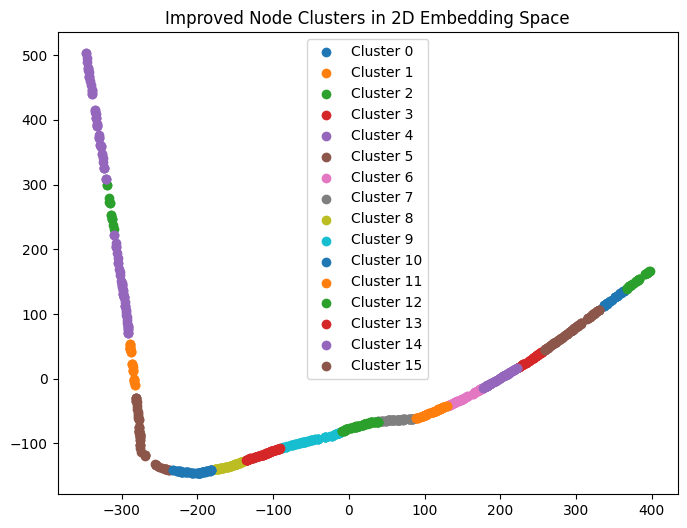

In [ ]:
n_clusters=16
# Apply k-means clustering
'''kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # 7 clusters for 7 topics
#clusters = kmeans.fit_predict(z.detach().cpu().numpy())
clusters = kmeans.fit_predict(train_data)

#clusters = kmeans.fit_predict(x)
centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
n_centers=centers.shape[0]
OrgCenters=centers'''


#For spectral clustering
n_centers=n_clusters
clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(train_data)
#clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(z.detach().cpu().numpy())
#clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(x)
clusters = clustering_tr.labels_ # torch.tensor(clustering_tr.labels_, dtype=torch.float32)
ceee=np.zeros((n_centers,z.detach().cpu().numpy().shape[1]))
for ndx in range(n_centers):
  #cen=z.detach().cpu().numpy()[clustering_tr.labels_ == ndx]
  cen=train_data[clustering_tr.labels_ == ndx]
  print(cen.mean(axis=0))
  ceee[ndx]=cen.mean(axis=0)
centers=torch.tensor(ceee, dtype=torch.float32)
n_centers=centers.shape[0]
OrgCenters=centers

# Evaluate clustering (optional, if labels are available)
#ari = adjusted_rand_score(data.y.cpu().numpy(), clusters)
ari = adjusted_rand_score(train_labels, clusters)
print(f'Adjusted Rand Index: {ari:.4f}')

# Visualize the clusters
pca = PCA(n_components=2)
#z_2d = pca.fit_transform(z.detach().cpu().numpy())
z_2d = pca.fit_transform(train_data)
plt.figure(figsize=(8, 6))
for i in range(n_clusters):  # Assuming 7 clusters
    plt.scatter(z_2d[clusters == i, 0], z_2d[clusters == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Improved Node Clusters in 2D Embedding Space')
plt.show()

In [ ]:
# Apply k-means clustering
''''kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # 7 clusters for 7 topics
clusters = kmeans.fit_predict(z.detach().cpu().numpy())
centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
n_centers=centers.shape[0]''''

#For spectral clustering on TRAINING SET ONLY
n_centers=n_clusters
#clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(z.detach().cpu().numpy())
clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(train_data)
#clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(x)
clusters = clustering_tr.labels_ # torch.tensor(clustering_tr.labels_, dtype=torch.float32)
ceee=np.zeros((n_centers,z.detach().cpu().numpy().shape[1]))
for ndx in range(n_centers):
  #cen=z.detach().cpu().numpy()[clustering_tr.labels_ == ndx]
  cen=train_data[clustering_tr.labels_ == ndx]
  print(cen.mean(axis=0))
  ceee[ndx]=cen.mean(axis=0)
centers=torch.tensor(ceee, dtype=torch.float32)
n_centers=centers.shape[0]
OrgCenters=centers

# Evaluate clustering (optional, if labels are available)
#ari = adjusted_rand_score(data.y.cpu().numpy(), clusters)
ari = adjusted_rand_score(train_labels, clusters)
print(f'Adjusted Rand Index: {ari:.4f}')

# Visualize the clusters
pca = PCA(n_components=2)
#z_2d = pca.fit_transform(z.detach().cpu().numpy())
z_2d = pca.fit_transform(train_data)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):  # Assuming 7 clusters
    plt.scatter(z_2d[clusters == i, 0], z_2d[clusters == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Improved Node Clusters in 2D Embedding Space')
plt.show()

SyntaxError: unterminated string literal (detected at line 12) (ipython-input-79-536022770.py, line 12)

In [ ]:
print(torch.randn(x.size(0), x.size(1)))

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import numpy as np
from torch_geometric.utils import to_networkx

# Assuming you have 'data', 'model', and 'num_nodes' defined

# Create the first graph (G)
G = to_networkx(data, to_undirected=True)
node_colors_G = ['red' if data.y[i].item() == 0 else 'blue' for i in range(num_nodes)]

#dgi_model.eval()
#z = dgi_model.encoder(data.x, data.edge_index)  # Improved embeddings
# Create the second graph (G_pred)
#out = model(data.x, data.edge_index)
pred = z.argmax(dim=1)
#pred = train_data.argmax(dim=1)
# Create a PyG Data object
data_refined = Data(x=z, edge_index=edge_index, y=y)
#data=dataset[0]
G_pred = to_networkx(data_refined, to_undirected=True)
#node_colors_G_pred = ['red' if pred[i] == 0 else 'blue' for i in range(num_nodes)]


#For spectral clustering on WHOLE Z(training and testing)
n_centers=n_clusters
clustering_trZ = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(z.detach().cpu().numpy())
#clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(train_data)
#clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(x)
clustersZ = clustering_trZ.labels_ # torch.tensor(clustering_tr.labels_, dtype=torch.float32)

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 4))  # 1 row, 2 columns

# Plot the first graph on the first subplot
nx.draw(G, with_labels=False, node_color=node_colors_G, node_size=10, edge_color='gray', ax=axes[0])
axes[0].set_title('Original Graph (G)')

nx.draw(G_pred, with_labels=False, node_color=node_colors_G, node_size=10, edge_color='gray', ax=axes[1])
axes[1].set_title('Refined Graph (G)')
plt.show()


cluster_colors = ['red', 'blue', 'green', 'yellow', 'pink','orange', 'purple','brown'] #'lime', 'orchid', 'gold', 'teal'
cluster_colors = ['red', 'blue', 'green', 'yellow', 'pink','orange', 'purple','brown','black','magenta','violet','skyblue','cyan','lime', 'orchid', 'gold'] # One color per cluster

node_colors_G_predicted = [cluster_colors[label] for label in clustersZ]


# Display Full Graph Structure (NOT OF THE TRAINED SUB_GRAPH)

plt.figure(figsize=(5, 4))
nx.draw(G, with_labels=False, node_color='blue', node_size=10, edge_color='gray')
nx.draw(G_pred, with_labels=False, node_color=node_colors_G_predicted, node_size=10, edge_color='none',ax=plt.gca())
#plt.gca().set_title('Learned Graph Representation')
plt.show()

In [ ]:
###TRIED TO SEE CLUSTERED GRAPH ON TRAINED DATA ONLY NOT WORKING

#data_refined is the graph on Z data defined in previous cell
'''data_refined.train_mask = train_mask
data_refined.test_mask = test_mask

from torch_geometric.utils import to_networkx, subgraph
train_node_indices = torch.nonzero(data_refined.train_mask).squeeze()

# Extract the subgraph using the train_node_indices
edge_index_subgraph, _ = subgraph(train_node_indices, data_refined.edge_index)

# Create a new Data object for the subgraph
data_subgraph = Data(x=data_refined.x[train_node_indices],
                    edge_index=edge_index_subgraph,
                    y=data_refined.y[train_node_indices])

# Convert the subgraph to a NetworkX graph
G_train_mask = to_networkx(data_subgraph, to_undirected=True)

#For spectral clustering on WHOLE Z(training part ONLY)
n_centers=n_clusters
clustering_trT = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(z[train_mask].detach().cpu().numpy())
#clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(train_data)
#clustering_tr = SpectralClustering(n_clusters=n_centers,assign_labels='cluster_qr',affinity='nearest_neighbors' ,random_state=0).fit(x)
clustersT = clustering_trT.labels_ # torch.tensor(clustering_tr.labels_, dtype=torch.float32)

# Color nodes based on their cluster labels within the subgraph
#node_colors_G_train_mask = [cluster_colors[label] for label in range(clusters_subgraph)]
node_colors_G_train_mask = [cluster_colors[label] for label in clustersT]#[train_node_indices]]  # Color nodes based on their cluster labels
# Get node colors for the subgraph

# ... (rest of your code for visualization) ...

# Plot the subgraph for train_mask
plt.figure(figsize=(5, 4))
nx.draw(G_train_mask, with_labels=False, node_color=node_colors_G_train_mask,
        node_size=10, edge_color='gray', ax=plt.gca())
plt.gca().set_title('Graph Structure for train_mask Data')
plt.show()'''

In [ ]:
print(data_refined.x.shape)
print(data.x.shape)

In [ ]:
centers.shape

In [ ]:
for i in range(n_centers):
    print(f"Center {i} (label {i}): {centers[i]}")

In [ ]:
# Assuming `centers` is your tensor of cluster centers and `labels` is the array of labels
centers=OrgCenters

for i in range(n_centers):
    print(f"Center {i} (label {i}): {centers[i]}")


In [ ]:
# Split the dataset into training and testing sets
#x=z #.detach().cpu().numpy()
'''X_train, X_test, y_train, y_test = train_test_split(z.detach().cpu().numpy(), y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)'''

X_train_st=torch.tensor(train_data, dtype=torch.float32)
X_test_st=torch.tensor(test_data, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.float32)


'''X_train, X_test, y_train, y_test = train_test_split(z.detach().cpu().numpy(), y, test_size=0.3, random_state=0)'''

# Standardize the data
# Convert data to PyTorch tensors
'''X_train_st = torch.tensor(X_train_st, dtype=torch.float32)
X_test_st = torch.tensor(X_test_st, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)'''
# Check the shapes of the tensors
print(X_train_st.shape, y_train.shape)
print(X_test_st.shape, y_test.shape)

In [ ]:
print(z[1,:])
print(x[1,:])

In [ ]:
import numpy as np
lam_wt=np.linspace(1e-10,1e-5,20)
lam_cen=np.linspace(1e-10,1e-5,20)
for i,j in zip(lam_wt,lam_cen):
  print(i,j)

In [ ]:
batch_size = 128
step_size = 0.01  #learning rate

# Create data loaders
train_dataset = TensorDataset(X_train_st, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

bestTest_acc=0
bestTrain_acc=0
best_wtReg=0
best_cenReg=0
n_epochs =2000
Acc_list=[]
wtReg_list=[]
cenReg_list=[]
Acc_listSimples=[]
learnable_centers=True
gaussian_reg=1e-2
lam_wt=np.linspace(1e-10,1e-5,5)
lam_cen=np.linspace(1e-10,1e-5,5)
biasReg=1e-2
counter=0
for weights_reg,centers_reg in zip(lam_wt,lam_cen):
  counter=counter+1
  centerss=torch.tensor(OrgCenters,dtype=torch.float32)
  # Create the Gaussian RBF network
  model = GaussianRBFNetworkC(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg,
                            weights_regularizer=weights_reg, learnable_centers=learnable_centers, centers=centerss,
                            device='cpu')
  #model = GaussianRBFNetworkCBias(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg,
  #                          weights_regularizer=weights_reg, bias_regularizer=biasReg, learnable_centers=learnable_centers, centers=centerss,
  #                          device='cpu')


  # Training loop
  optimizer = GCAdam(model.parameters(), lr=step_size) #GCAdam(model.parameters(), lr=step_size)

  for epoch in range(n_epochs):
      model.train()
      epoch_loss = 0.0
      for batch_X, batch_y in train_loader:
          optimizer.zero_grad()
          y_hat = model(batch_X)
          loss = model.evaluate_loss(batch_y, y_hat)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()

      if epoch % 500 == 0:
          print(f'Iter No : {counter}, Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')
  # Evaluate the model
  model.eval()
  with torch.no_grad():
      #y_train_pred = np.round(model(X_train_st).numpy(),1)>=0.5 #0.4#0.5
      #y_test_pred = np.round (model(X_test_st).numpy(),1) >=0.5#0.4# 0.5
      y_train_pred = model(X_train_st).numpy()>0.5 #0.4#0.5
      y_test_pred = model(X_test_st).numpy() >0.5#0.4# 0.5

  train_accuracy = accuracy_score(y_train.numpy(), y_train_pred)
  test_accuracy = accuracy_score(y_test.numpy(), y_test_pred)
  Acc_listSimples.append(test_accuracy)
  #train_accuracy = accuracy_score(y_train, y_train_pred)
  #test_accuracy = accuracy_score(y_test, y_test_pred)
  #old accucracy
  print(f'Simple Tr_Accu: {train_accuracy}, Simple Te_Acc: {test_accuracy}')
  #th_train:{th_train},th_test:{th_test}')

  model.eval()
  with torch.no_grad():
    predictions_train = model(X_train_st).detach().numpy()
    predictions_test = model(X_test_st).detach().numpy()
  threshold_optionn=1
  th_train=threshold_option(y_train.numpy(),predictions_train,threshold_optionn)
  th_test=threshold_option(y_test.numpy(),predictions_test,threshold_optionn)
  #y_pred_train = binary_predictions(predictions_train)
  #y_pred_test = binary_predictions(predictions_test)
  y_pred_train = binary_predictions(predictions_train,th_train)#train_threshold)
  y_pred_test = binary_predictions(predictions_test,th_test)#test_threshold)
  # Calculate accuracy
  train_accuracy = accuracy_score(y_train.numpy(), y_pred_train)
  test_accuracy = accuracy_score(y_test.numpy(), y_pred_test)
  print(f'TrTh Accu: {train_accuracy}, TeTh_Acc: {test_accuracy}, th_train:{th_train},th_test:{th_test}')
  #print(f'Train Accuracy: {train_accuracy}')
  #print(f'Test Accuracy: {test_accuracy}')

  Acc_list.append(test_accuracy)
  wtReg_list.append(weights_reg)
  cenReg_list.append(centers_reg)

  if test_accuracy>bestTest_acc:
    bestTest_acc=test_accuracy
    bestTrain_acc=train_accuracy
    best_wtReg=weights_reg
    best_cenReg=centers_reg
    print(f'Best Tr Accu: {bestTrain_acc}, Best Te_Acc: {bestTest_acc}, c_reg: {best_cenReg}, w_reg:{best_wtReg}')
Acc_Option=1
for simple_acc,thresh_acc in zip(Acc_listSimples,Acc_list):
  if simple_acc>bestTest_acc:
    Acc_Option=0
    break
  if Acc_Option==1:
    break

In [ ]:
Acc_Option

In [ ]:
#test_f1 = f1_score(y_test.numpy(), y_pred_test.numpy())
#print(test_f1)

In [ ]:
if Acc_Option==0:
  mean_accuracy = np.mean(Acc_listSimples)
  idx_maxAcc = np.argmax(Acc_listSimples)
  max_valueAcc = Acc_listSimples[idx_maxAcc]
  max_valuewtReg = wtReg_list[idx_maxAcc]
  max_valuecenReg = cenReg_list[idx_maxAcc]
  print(f'Mean Accuracy Simple: {mean_accuracy}')
  print(f'max_Acc Simple: {max_valueAcc}, max_wtReg: {max_valuewtReg}, max_cenReg: {max_valuecenReg}')
else:
  mean_accuracy = np.mean(Acc_list)
  idx_maxAcc = np.argmax(Acc_list)
  max_valueAcc = Acc_list[idx_maxAcc]
  max_valuewtReg = wtReg_list[idx_maxAcc]
  max_valuecenReg = cenReg_list[idx_maxAcc]
  print(f'Mean Accuracy Threshold: {mean_accuracy}')
  print(f'max_Acc Threshold: {max_valueAcc}, max_wtReg: {max_valuewtReg}, max_cenReg: {max_valuecenReg}')

In [ ]:
print(f'Best Tr Accu: {bestTrain_acc}, Best Te_Acc: {bestTest_acc}, c_reg: {best_cenReg}, w_reg:{best_wtReg}')

In [ ]:
learnable_centers=False
gaussian_reg, centers_reg, weights_reg= 1e-2, None, 1e-5
learnable_centers=True
gaussian_reg, centers_reg, weights_reg= 1e-2, 1e-5, 1e-5
#gaussian_reg, centers_reg, weights_reg= 1e-10, 1e-15, 1e-15
#gaussian_reg, centers_reg, weights_reg= 1e-2, 7.9166875e-06, 7.9166875e-06
#center_reg=max_valuecenReg
#weight_reg=max_valuewtReg
biasReg=0
batch_size = 128
step_size = 0.01  #learning rate
centerss=torch.tensor(OrgCenters,dtype=torch.float32)
model = GaussianRBFNetworkC(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg,
                            weights_regularizer=weights_reg, learnable_centers=learnable_centers, centers=centerss,
                            device='cpu')
#model = GaussianRBFNetworkCBias(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg,
#                            weights_regularizer=weights_reg, bias_regularizer=biasReg, learnable_centers=learnable_centers, centers=centerss,
#                            device='cpu')
# Create data loaders
#train_dataset = TensorDataset(X_train_st, y_train)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Training settings using GCADAM optimizer instead of ADAM
optimizer = GCAdam(model.parameters(), lr=step_size) #GCAdam(model.parameters(), lr=step_size)

##replace  with GCADAM
n_epochs = 2000

# Training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_hat = model(batch_X)
        loss = model.evaluate_loss(batch_y, y_hat)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')


In [ ]:

print(model.weights_regularizer)
print(model.gaussian_regularizer)
print(model.centers_regularizer)
#print(model.bias_regularizer)

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    #y_train_pred = np.round(model(X_train_st).numpy(),1)>=0.5 #0.4#0.5
    #y_test_pred = np.round (model(X_test_st).numpy(),1) >=0.5#0.4# 0.5
    y_train_pred = model(X_train_st).numpy()>0.5 #0.4#0.5
    y_test_pred = model(X_test_st).numpy() >0.5#0.4# 0.5

train_accuracy = accuracy_score(y_train.numpy(), y_train_pred)
test_accuracy = accuracy_score(y_test.numpy(), y_test_pred)

#train_accuracy = accuracy_score(y_train, y_train_pred)
#test_accuracy = accuracy_score(y_test, y_test_pred)
#old accucracy
print(f'Tr Accu Simple: {train_accuracy}, Te_Acc Simple: {test_accuracy}')

model.eval()
with torch.no_grad():
  predictions_train = model(X_train_st).detach().numpy()#>0.5 #0.4#0.5
  predictions_test = model(X_test_st).detach().numpy() #>0.5#0.4# 0.5
threshold_optionn=Acc_Option
th_train=threshold_option(y_train.numpy(),predictions_train,threshold_optionn)
th_test=threshold_option(y_test.numpy(),predictions_test,threshold_optionn)
#y_pred_train = binary_predictions(predictions_train)
#y_pred_test = binary_predictions(predictions_test)
y_pred_train = binary_predictions(predictions_train,th_train)#train_threshold)
y_pred_test =torch.tensor(binary_predictions(predictions_test,th_test),dtype=torch.float32) #test_threshold)
# Calculate accuracy
train_accuracy = accuracy_score(y_train.numpy(), y_pred_train)
test_accuracy = accuracy_score(y_test.numpy(), y_pred_test.numpy())
print(f'TrTh Accu: {train_accuracy}, TeTh_Acc: {test_accuracy}')
#print(f'Train Accuracy: {train_accuracy}')
#print(f'Test Accuracy: {test_accuracy}')

#from sklearn.inspection import DecisionBoundaryDisplay
colr=[]
for idx in range(y_pred_test.shape[0]):
  if y_pred_test[idx]==0:
    colr.append('purple')
  else:
    colr.append('yellow')

#
#plt.scatter(X_test[:, 3], X_test[:, 5], c=y_test,s=20, edgecolors="k")

plt.scatter(X_test_st[:, 0], X_test_st[:,1], c=y_test, s=30, edgecolors="k")
plt.show()
plt.scatter(X_test_st[:, 0], X_test_st[:, 1], c=colr, s=30, edgecolors="k")
plt.show()

In [ ]:
y_pred_test.shape[0]

In [ ]:
print(y_pred_test,y_test, th_test, th_train)


In [ ]:
# Extract feature importance
precision_matrix = model.compute_precision(model.precision_elements)
feature_importance1, eigenvalues, eigenvectors = model.feature_importance(precision_matrix)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Example feature_importance (assuming it is a torch tensor from your model)
# You need to replace this with actual feature importance from your model
#feature_importance = torch.rand(13)  # Assuming 13 features in the heart dataset

# Detach if required and convert to numpy array
feature_importance = feature_importance1.detach().numpy()

# Assuming X is the feature matrix and y is the target
# Replace X and y with actual data from your heart dataset
# For example, X_train, y_train from the split step
mean_no_disease = X[y == 0].mean(axis=0)  # Mean of class '0' (no heart disease)
mean_disease = X[y == 1].mean(axis=0)     # Mean of class '1' (heart disease)

# Plot the feature importance and class means
plt.figure(figsize=(18, 6))

# Plot 1: Feature Importance as a bar plot
plt.subplot(1, 3, 1)
#plt.title("Feature Importance")
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(np.arange(len(feature_importance)))

''''# Plot 2: Mean of Class '0' (No Heart Disease) as a heatmap
plt.subplot(1, 3, 2)
plt.title("Mean of Class '0' (No Heart Disease)")
sns.heatmap(mean_no_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=X.shape[1])#data.columns[:-1])
plt.yticks([])

# Plot 3: Mean of Class '1' (Heart Disease) as a heatmap
plt.subplot(1, 3, 3)
plt.title("Mean of Class '1' (Heart Disease)")
sns.heatmap(mean_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=X.shape[1])#data.columns[:-1])
plt.yticks([])'''

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Plot eigenvalues decay
gammas = eigenvalues.detach().numpy()[::-1] # sort eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(gammas) + 1), gammas / np.sum(gammas), marker='o', linestyle='-',linewidth=2.5)
plt.xlabel('$k$')
#plt.title("Eigenvalues Decay")
plt.ylabel(r'$\frac{\gamma_k}{\sum_k^K \gamma_k}$')
plt.tight_layout()
plt.show()

In [ ]:
# Plot contours

V = eigenvectors.detach().numpy()[:, ::-1] # sort eigenvectors
Z = np.dot(X_test_st, V[:, :2]) # project data into the latent or active subspace defined by the top-2 eigenvectors

lb1, ub1 = min(Z[:, 0]), max(Z[:, 1])
lb2, ub2 = min(Z[:, 0]), max(Z[:, 1])
xx1 = np.linspace(lb1, ub1, 100)
xx2 = np.linspace(lb2, ub2, 100)

XX1, XX2 = np.meshgrid(xx1, xx2)
xx12 = np.vstack([XX1.ravel(), XX2.ravel()]).T
xx12_back = np.dot(xx12, V[:, :2].T) # reproject back data from the active subspace so that we can evaluate the model
xx12_back = torch.tensor(xx12_back, dtype=torch.float32)
model.eval()
with torch.no_grad():

    #XX3 = (np.round(model(xx12_back).detach().numpy(),1)).reshape(XX1.shape) # obtan the model output
#XX3 = (np.round(model(xx12_back).detach().numpy(),1)).reshape(XX1.shape) # obtan the model output
  XX3 = (model(xx12_back).detach().numpy()>th_test).reshape(XX1.shape) # obtan the model output
  #XX3 = (model(xx12_back).detach().numpy()>0.5).reshape(XX1.shape) # obtan the model output
fig, ax = plt.subplots(figsize=(8, 6))
# Plot centers
#centers_projected = np.dot(model.centers.detach().numpy(), V[:, :2])

contours = plt.contourf(XX1, XX2, XX3, cmap='plasma', levels=np.linspace(0, 1, 11))
cbar = plt.colorbar(contours)
cbar.set_label('Model output')
cbar.set_ticks(np.linspace(0, 1, 11))

plt.scatter(Z[:, 0], Z[:, 1], c=y_test, edgecolors='black')
#plt.scatter(Z[:, 0], Z[:, 1], edgecolors='black')
#plt.scatter(centers_projected[:, 0], centers_projected[:, 1], c='red', marker='x', label='Centers')
ax.set_xlim(XX1.min(), XX1.max())
ax.set_ylim(XX2.min(), XX2.max())

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
#plt.title('Active Subspace in 2D')
#plt.legend()
plt.tight_layout()

In [ ]:
# Visualize the clusters

Z = np.dot(X_test_st, V[:, :2])

pca = PCA(n_components=2)
z_2d = pca.fit_transform(Z)
plt.figure(figsize=(8, 6))
for i in range(2):  # Assuming 7 clusters
    if i==0:
        plt.scatter(z_2d[:,0], z_2d[:,1], c=(y_test==0), label=f'Label {0}')
    else:
      plt.scatter(z_2d[:,0], z_2d[:,1], c=(y_test==1), label=f'Label {1}')
plt.legend()
plt.title('Actual Node Clusters in 2D Embedding Space')
plt.show()


Z=torch.tensor(Z,dtype=torch.float32)

y_test_prd = model(X_test_st).detach().numpy()>th_test#.reshape(XX1.shape)
#th_test=0.5
#pca = PCA(n_components=2)
#z_2d = pca.fit_transform(XX3)
plt.figure(figsize=(8, 6))
for i in range(2):  # Assuming 7 clusters
    if i==0:
        plt.scatter(z_2d[:,0], z_2d[:,1], c=(y_test_prd<th_test), label=f'Label {0}')
    else:
      plt.scatter(z_2d[:,0], z_2d[:,1], c=(y_test_prd>th_test), label=f'Label {1}')
plt.legend()
plt.title('Predicted Node Clusters in 2D Embedding Space')
plt.show()

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
if XX3.dtype == bool:                #added
    XX3 = XX3.astype(float)          #added
surf = ax.plot_surface(XX1, XX2, XX3, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(XX3.min(), XX3.max())
ax.set_xlim(XX1.min(), XX1.max())
ax.set_ylim(XX2.min(), XX2.max())
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xticks(())
ax.set_yticks(())
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
# Apply SVM Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc=SVC()
svc=SVC(kernel="rbf", gamma=0.5, C=4.0)
svc.fit(X_train_st, y_train)
y_pred=svc.predict(X_test_st.detach().numpy())
print('Model accuracy : {0:0.3f}'. format(accuracy_score(y_test.detach().numpy(), y_pred)))


In [ ]:
plt.scatter(X_test_st[:, 2], X_test_st[:, 3], c=y_test, edgecolors='black')
#plt.scatter(centers_projected[:, 0], centers_projected[:, 1], c='red', marker='x', label='Centers')

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.title('Active Subspace in 2D')
#plt.legend()
plt.tight_layout()

In [ ]:
# Plot contours

V = eigenvectors.detach().numpy()[:, ::-1] # sort eigenvectors
Z = np.dot(X_test_st, V[:, :2]) # project data into the latent or active subspace defined by the top-2 eigenvectors

lb1, ub1 = min(Z[:, 0]), max(Z[:, 0])
lb2, ub2 = min(Z[:, 1]), max(Z[:, 1])
xx1 = np.linspace(lb1, ub1, 100)
xx2 = np.linspace(lb2, ub2, 100)

XX1, XX2 = np.meshgrid(xx1, xx2)
xx12 = np.vstack([XX1.ravel(), XX2.ravel()]).T
xx12_back = np.dot(xx12, V[:, :2].T) # reproject back data from the active subspace so that we can evaluate the model
xx12_back = torch.tensor(xx12_back, dtype=torch.float32)

#XX3 = (np.round(model(xx12_back).detach().numpy(),1)).reshape(XX1.shape) # obtan the model output
XX3 = svc.predict(xx12_back).reshape(XX1.shape) # obtan the model output

XX3 = svc.predict(xx12_back).reshape(XX1.shape) # obtan the model output

fig, ax = plt.subplots(figsize=(8, 6))
# Plot centers
centers_projected = np.dot(model.centers.detach().numpy(), V[:, :2])

contours = plt.contourf(XX1, XX2, XX3, cmap='viridis', levels=np.linspace(0, 1, 11))
cbar = plt.colorbar(contours)
cbar.set_label('Model output')
cbar.set_ticks(np.linspace(0, 1, 11))

plt.scatter(Z[:, 0], Z[:, 1], c=y_test, edgecolors='black')
#plt.scatter(centers_projected[:, 0], centers_projected[:, 1], c='red', marker='x', label='Centers')

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.title('Active Subspace in 2D')
plt.legend()
plt.tight_layout()

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX1, XX2, XX3, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(XX3.min(), XX3.max())
ax.set_xlim(XX1.min(), XX1.max())
ax.set_ylim(XX2.min(), XX2.max())
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xticks(())
ax.set_yticks(())
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()